# Extracting Period Information

In this tutorial, we will go through
- loading variable star data using Astropy
- extracting period information using the Lomb-Scargle Periodogram
- looking at where variables lie in the HR diagram
- making a period-luminosity relation

You don't have to cut and paste code - if you clone this git repository `https://github.com/benjaminpope/ladder`, these examples will be available under `docs/notebooks`.

First, let's load all the Python packages we'll need.

In [125]:
import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going

import os 

import pandas as pd # pandas is a popular library in industry for manipulating large data tables

from astropy.timeseries import LombScargle

# configure notebook for plotting
%matplotlib inline

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)   
matplotlib.rcParams['font.size']=16              
matplotlib.rcParams['savefig.dpi']= 300             

import warnings
warnings.filterwarnings('ignore')

## Load some data

Let's pick a data directory from files I prepared earlier. These were from an earlier run of the universe-making code and don't belong to any group in this project!

In [126]:
ddir_stars = '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)/'

ddir = ddir_stars + '/Variable_Star_Data/'

What's in the directory?

Let's pick and load a single .csv file of a light curve. In this tutorial we'll use Astropy, a standard Python library for astronomical data; if you know Pandas, this is more common in data science and has similar functionality. Use whatever you like! 

We're first going to calculate the Nyquist limit - you can't pick out a period shorter than twice the rate at which you get time samples. As these data are hourly, it means we can't measure periods shorter than 2 hours. Because it's linear in Fourier space, we'll usually work in *frequency* rather than period, but use whichever you wish - so long as you're careful!

In [127]:
fname = 'FrontS038389.csv'

data = pd.read_csv(ddir+fname) # load in CSV data as a Pandas object
print(data.keys()) # see what's in it
time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables
dt = np.median(np.diff(time))
print('Nyquist Limit',0.5/dt,'cycles per hour') # can't get frequencies higher than the Nyquist limit

Index(['Time', 'NormalisedFlux'], dtype='object')
Nyquist Limit 0.5 cycles per hour


Text(0, 0.5, 'Relative Flux')

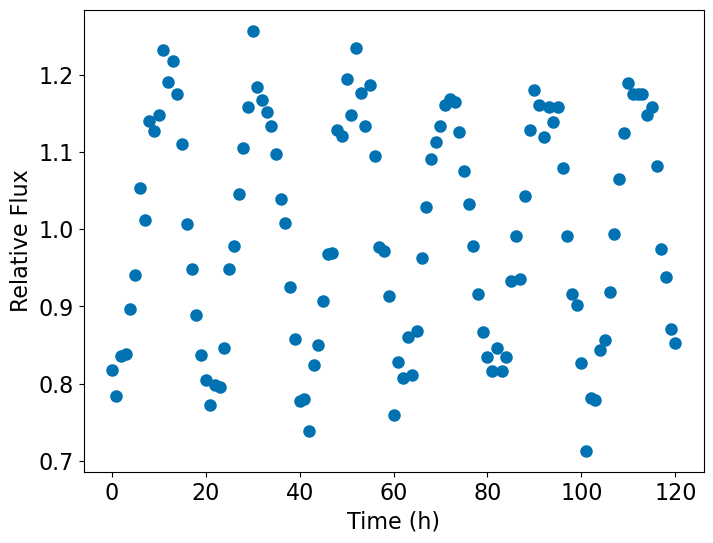

In [128]:
plt.plot(time,flux,'.',markersize=16)
plt.xlabel('Time (h)')
plt.ylabel('Relative Flux')

## Lomb-Scargle Periodograms

The Lomb-Scargle periodogram is named because it was first used in the PhD thesis of the former director of Sydney Observatory, Nick Lomb. It is probably the most widely cited Australian astronomy paper! If you want to determine the periodic content (Fourier power spectrum) of a time series - including if it is sparsely or irregularly sampled - it is the algorithm to go to. Rather than using the Fast Fourier Transform, the LS periodogram simply does a least squares fit against sines and cosines - this can be done very fast, and applied to nonuniform data. 

In [129]:
LS = LombScargle(time,flux) # initialize a Lomb-Scargle algorithm from Astropy
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
power = LS.power(freqs) # calculate LS power 


In [130]:
print('Best period: %.2f h' % (1/freqs[np.argmax(power)]))

Best period: 20.16 h


Text(0, 0.5, 'LS Power')

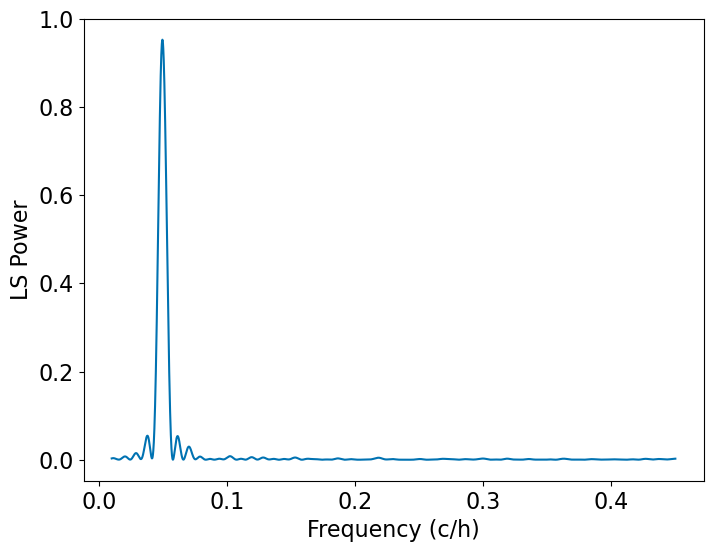

In [131]:
plt.plot(freqs,power)
plt.xlabel('Frequency (c/h)')
plt.ylabel('LS Power')

### Now let's loop over all the stars in the directory!

In [132]:
import glob # this package lets you search for filenames

fnames = glob.glob(ddir+'*.csv')
print(fnames[:10])

['/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/BottomS183263.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/BackS155645.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/LeftS137039.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/LeftS139014.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/TopS009921.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/FrontS037994.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Variable_Star_Data/LeftS134256.csv', '/Users/benjaminpope/code/Simulated-Universe/Datasets/Sim Data (Clusters; 200, Seed; 6683)//Va

Below we are going to make plots of a subset of data these data - this is always a good idea before running a large computation, just to see what you have visually. This is the first thing every data scientist does with new data! 

I encourage you to look at these plots, as you'll see that one dataset is too noisy, and we don't get a good sinusoidal fit to it. You can comment out the plotting code if you run it on lots of datasets though!

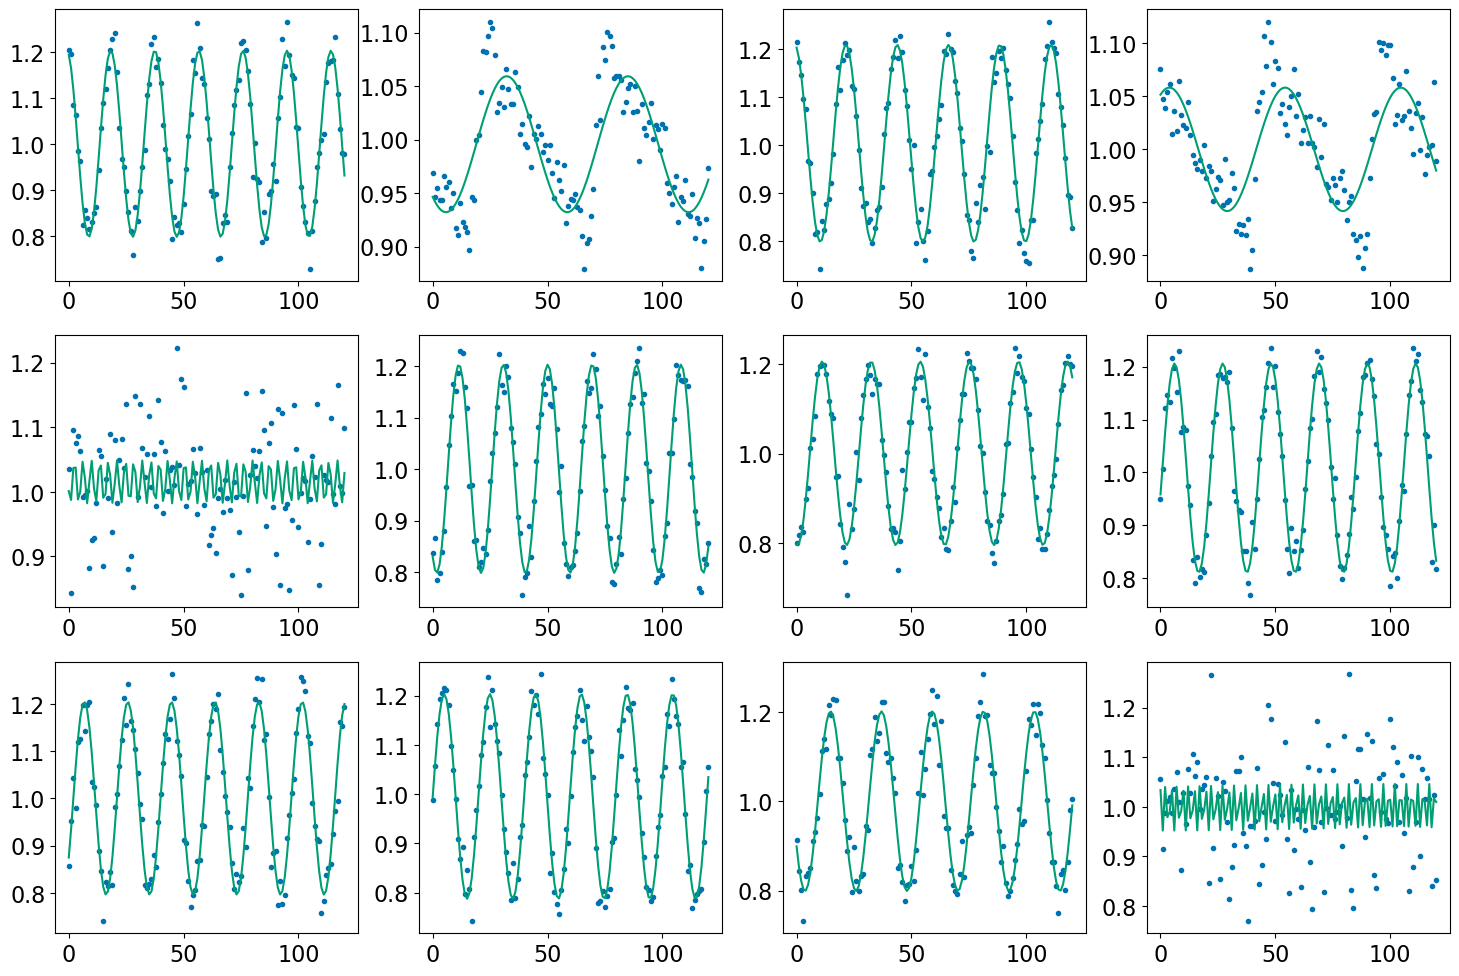

In [133]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 

fig, axes = plt.subplots(3,4,figsize=(18,12))
for fname, ax in zip(fnames[:12], axes.ravel()): # you can loop over two things
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    ax.plot(time,flux,'.')
    ax.plot(time,pred) # plot the model over the data
    
    periods.append(1/bestfreq) # add each period to the list
    
periods = np.array(periods) # turn it from a list to an array

It looks like a few of them are dominated by noise!

Now let's loop over all of them without plotting:

In [134]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 
names = []

for fname in tqdm(fnames): # tqdm is a package that gives you a progress bar - neat! 
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    
    periods.append(1/bestfreq) # add each period to the list
    names.append(os.path.basename(fname).strip('.csv')) # os.path.basename gets rid of directories and gives you the filename; then we strip '.csv'
    
periods = np.array(periods) # turn it from a list to an array

100%|██████████| 6916/6916 [01:22<00:00, 83.69it/s] 


## HR Diagram and Period-Luminosity Relation

In [136]:
import glob # this package lets you search for filenames
import os

variables = pd.DataFrame({'Name':names,
              'Period':periods}) # you can turn a dictionary into a dataframe like this
variables.Name = variables.Name.astype('|S') # have to do this so that it knows the names are strings

all_star_files = glob.glob(ddir_stars+'*/Star_Data.csv')

all_stars = pd.concat([pd.read_csv(table) for table in all_star_files]) # we are concatenating a list of dataframes; 
#we generate this list with a "list comprehension", a loop you write inside a list bracket 

all_stars.Name = all_stars.Name.astype('|S') # have to do this so that it knows the names are strings
all_stars = all_stars[all_stars.Parallax > 0.01] # 10 mas parallax cut
print(len(all_stars),'stars above 10 mas parallax') # check how many stars there are total with good parallax

variables = pd.merge(all_stars,variables,on='Name') # merge these two arrays according to the keyword 'name'
print('Of which',len(variables),'variables') # cut down to a small list


860 stars above 10 mas parallax
Of which 46 variables


Let's make an HR diagram. One thing to keep in mind is that our convention of using magnitudes is just to match our modern scale to the Ancient Greeks - in your fantasy universe, you can use whatever units you like (but I recommend that they be logarithmic!). This is an important note - lots of students get hung up on the -2.5 and the solar luminosity, but these are just conventions in our world that aren't important for the physics.

So let's have a simple log scale for magnitude here.

In [137]:
m0, m1, m2 = np.log10(all_stars['BlueF']), np.log10(all_stars['GreenF']), np.log10(all_stars['RedF']) 
colour = m2-m0
abs_mag = m1 + 2*np.log10(1./all_stars.Parallax) 

v0, v1, v2 = np.log10(variables['BlueF']), np.log10(variables['GreenF']), np.log10(variables['RedF']) 
variable_colour = v2-v0
abs_mag_v = v1 + 2*np.log10(1./variables.Parallax) 


Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

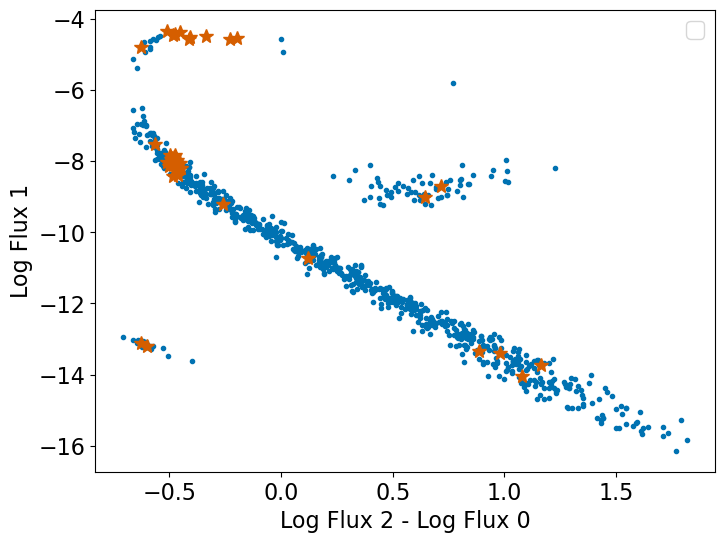

In [138]:
s = plt.plot(colour,abs_mag,'.C0')
h = plt.plot(variable_colour,abs_mag_v,'.C2',marker='*',markersize=10)

    
plt.legend([s, h],['Steady','Variable'])
plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

So we see there are several kinds of variable in this stellar population - I wonder what their properties are?

### Period-Luminosity Diagram
Now let's make a period-luminosity diagram. Can we distinguish these stars by period, and anchor the distance ladder?

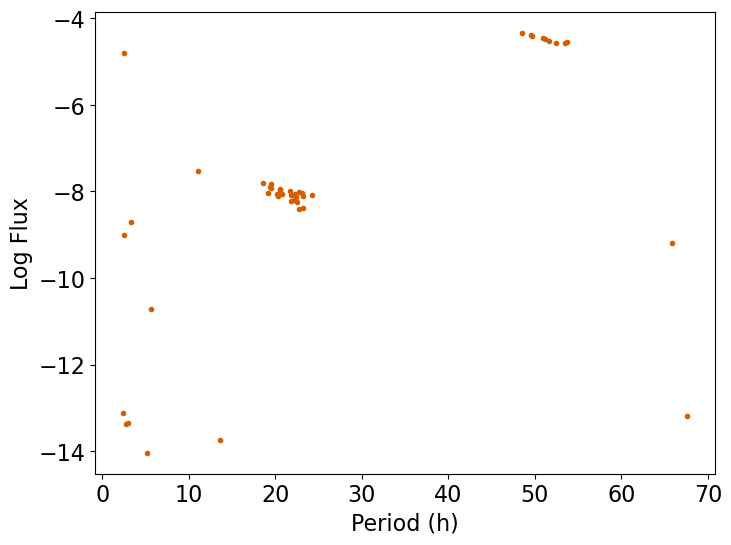

In [139]:
plt.plot(variables.Period,abs_mag_v,'.',color='C2')
plt.xlabel('Period (h)')
plt.ylabel('Log Flux');

Yes we can! We see two kinds of star - with a short and a long period - and possibly a linear trend in each dataset. Will this pan out? You'll have to look at more data! And it could be *very* different in your own analysis - all these universes are generated with random, made-up (but consistent) stellar physics.